In [549]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
house_file = pd.read_csv('../data/cleaned_complete.csv').drop(['Unnamed: 0.1','Unnamed: 0', 'index','dateUpdated','dateListed','geoLocation','geometry', 'index_right', 'SA2_maincode_2021','Population Increase','Earners (persons)','Median age of earners (years)','Male','Female',	'Person','Male Ratio','Female Ratio','Sum ($)','Mean ($)','Median ($)','propertyTypes','price'],axis = 1)


In [550]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1]).drop([(           'Unnamed: 0_level_0',      'SA2')], axis = 1)
income[(           'Unnamed: 2_level_0', 'Postcode')] = income[(           'Unnamed: 2_level_0', 'Postcode')].fillna(0)

In [551]:
name_income_dict = dict()
postcode_income_dict = dict()
for index, item in income.iterrows():
    name = item[(           'Unnamed: 1_level_0', 'SA2 NAME')].lower().replace('- ','')
    postcode_income = int(item[(           'Unnamed: 2_level_0', 'Postcode')])
    name_income_dict[name] = item
    postcode_income_dict[postcode_income] = item



def search_income(suburb_name,postcode):
    item = name_income_dict.get(suburb_name)
    if item is not None:
        return item
    item = postcode_income_dict.get(postcode)
    if item is not None:
        return item
    
    return None


In [552]:
income_list = []
l = []
col = None
for index, value in house_file.iterrows():
    item = search_income(value['surburb'], value['postcode'])
    if item is not None:
        l.append(list(item))
        col = item.index
    else:
        l.append([None]*len(col))


In [574]:
income = pd.DataFrame(l, columns=['SA2 NAME','Postcode','Earners_2019','Earners_2020','Earners_2021','Earners_2022','Median_age_2019','Median_age_2020','Median_age_2021','Median_age_2022','sum_2019','sum_2020','sum_2021','sum_2022','median_2019','median_2020','median_2021','median_2022','mean_2019','mean_2020','mean_2021','mean_2022'])
income

,SA2 NAME,Postcode,Earners_2019,Earners_2020,Earners_2021,Earners_2022,Median_age_2019,Median_age_2020,Median_age_2021,Median_age_2022,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
0,South Melbourne,3004.0,9313.509189,9774.078958,10199.816160,10199.816160,38.256757,38.337535,38.438722,38.565539,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
1,South Melbourne,3004.0,9313.509189,9774.078958,10199.816160,10199.816160,38.256757,38.337535,38.438722,38.565539,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
2,South Melbourne,3004.0,9313.509189,9774.078958,10199.816160,10199.816160,38.256757,38.337535,38.438722,38.565539,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
3,South Melbourne,3004.0,9313.509189,9774.078958,10199.816160,10199.816160,38.256757,38.337535,38.438722,38.565539,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
4,South Melbourne,3004.0,9313.509189,9774.078958,10199.816160,10199.816160,38.256757,38.337535,38.438722,38.565539,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,Bruthen - Omeo,3701.0,4748.426246,4857.851026,4963.045082,4963.045082,48.755000,48.374102,48.143569,47.856776,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100635,Bruthen - Omeo,3701.0,4748.426246,4857.851026,4963.045082,4963.045082,48.755000,48.374102,48.143569,47.856776,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100636,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100637,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [576]:
house = pd.concat([house_file, income],axis=1)
house 

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
0,1.0,1.0,0.0,NaN,3205,south melbourne,2019,1,NaN,360.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
1,2.0,2.0,1.0,NaN,3205,south melbourne,2019,1,NaN,725.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
2,1.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,500.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
3,1.0,3.0,0.0,NaN,3205,south melbourne,2019,1,NaN,795.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
4,2.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,825.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,1.0,3.0,1.0,NaN,3701,dartmouth,2022,5,NaN,280.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100635,1.0,3.0,1.0,NaN,3701,dartmouth,2022,6,NaN,290.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100636,1.0,3.0,2.0,NaN,3700,tallangatta,2022,8,NaN,470.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100637,1.0,3.0,2.0,NaN,3700,tallangatta,2021,3,NaN,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [577]:
house.to_csv('../data/curated/join.csv')

In [350]:
median_price = house_file.groupby(['bathrooms', 'bedrooms', 'carspaces','year','postcode'],as_index = False)['rent'].median('rent')
median_rent = dict()
for index, values in median_price.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    median_rent[key] = values['rent']
values_list = []
for item,values in house_file.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    hit = median_rent[key]
    values_list.append(hit)
house_file['median_rent'] = values_list 
house_file = house_file[house_file['rent'] <= 1.5 * house_file['median_rent']]
house_file = house_file[house_file['rent'] > 0.1 * house_file['median_rent']]

In [351]:
house_file

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,school,university,garden,park,playground,pitch,offence count,incidents recorded,Population,median_rent
0,1.0,1.0,0.0,NaN,3205,south melbourne,2019,1,NaN,360.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,790.0
1,2.0,2.0,1.0,NaN,3205,south melbourne,2019,1,NaN,725.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,565.0
2,1.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,500.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,570.0
3,1.0,3.0,0.0,NaN,3205,south melbourne,2019,1,NaN,795.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,580.0
4,2.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,825.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,1.0,3.0,1.0,NaN,3701,dartmouth,2022,5,NaN,280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,302.0,230.0,6181.185987,500.0
100635,1.0,3.0,1.0,NaN,3701,dartmouth,2022,6,NaN,290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,302.0,230.0,6181.185987,500.0
100636,1.0,3.0,2.0,NaN,3700,tallangatta,2022,8,NaN,470.0,...,NaN,NaN,NaN,NaN,NaN,NaN,605.0,484.0,6181.185987,500.0
100637,1.0,3.0,2.0,NaN,3700,tallangatta,2021,3,NaN,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,605.0,484.0,6153.000000,490.0


In [194]:
house_count = pd.DataFrame(house_file['postcode'].value_counts()).reset_index().rename({"index":"postcode",'postcode':'count'},axis = 1)
house_count

,postcode,count
0,3000,8652
1,3008,4253
2,3006,3066
3,3029,2823
4,3141,2552
...,...,...
461,3890,1
462,3453,1
463,3221,1
464,3870,1


In [217]:
df = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode','year','month'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall']).drop(['landAreaSqm','longitude', 'latitude'],axis = 1)
# df = df.rename({'surburb':'suburb'}, axis = 1)
df["postcode"] = df["postcode"].apply(lambda x: int(x))

In [218]:
df2 = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall']).drop(['landAreaSqm','longitude', 'latitude','year','month','Population '],axis = 1)
df2 = df2.rename({'surburb':'suburb'}, axis = 1)

In [219]:
df2["postcode"] = df2["postcode"].apply(lambda x: int(x))

In [220]:
df_combined = df.merge(house_count, on = 'postcode', how = 'left').fillna(0)
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,bond,rent,distance of the closest bus stop,count of bus stop,...,university,garden,park,playground,pitch,offence count,incidents recorded,Population,median_rent,count
0,0.0,1.0,0.0,3008,2019,12,5100.0,850.0,0.456268,5.0,...,0.0,0.0,1.0,0.0,0.0,25125.0,18185.0,16375.000000,850.0,4253
1,0.0,1.0,0.0,3015,2019,10,1084.0,250.0,0.370457,60.0,...,0.0,10.0,67.0,26.0,40.0,10604.0,8777.0,19243.000000,800.0,295
2,0.0,1.0,0.0,3053,2022,5,0.0,175.0,0.449442,39.0,...,0.0,8.0,19.0,8.0,24.0,20238.0,15867.0,16701.220181,430.0,1280
3,0.0,1.0,0.0,3079,2022,3,1304.0,300.0,0.516233,48.0,...,0.0,0.0,20.0,14.0,42.0,9248.0,7527.0,12678.988491,850.0,269
4,0.0,1.0,0.0,3171,2020,2,5000.0,460.0,0.642444,64.0,...,0.0,0.0,5.0,4.0,12.0,22113.0,16777.0,23636.000000,850.0,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44166,4.0,5.0,4.0,3064,2021,11,2340.0,540.0,0.386602,209.0,...,1.0,77.0,119.0,48.0,190.0,55237.0,41689.0,22005.000000,540.0,1482
44167,4.0,5.0,4.0,3133,2020,10,0.0,900.0,0.642555,64.0,...,0.0,0.0,4.0,0.0,2.0,7751.0,5998.0,11324.000000,900.0,232
44168,4.0,5.0,4.0,3335,2022,6,2824.0,650.0,0.129284,10.0,...,0.0,140.0,48.0,30.0,56.0,4762.0,3843.0,25309.447163,650.0,237
44169,4.0,5.0,4.0,3844,2019,8,0.0,570.0,1.741227,124.0,...,0.0,0.0,4.0,3.0,3.0,42754.0,29717.0,16489.000000,570.0,214


In [221]:
cpi_df = pd.read_csv('../data/cpi.csv').drop({'Unnamed: 0'}, axis = 1)
df_combined = df_combined.merge(cpi_df, on = 'year')
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,bond,rent,distance of the closest bus stop,count of bus stop,...,garden,park,playground,pitch,offence count,incidents recorded,Population,median_rent,count,cpi
0,0.0,1.0,0.0,3008,2019,12,5100.0,850.0,0.456268,5.0,...,0.0,1.0,0.0,0.0,25125.0,18185.0,16375.0,850.0,4253,255.65
1,0.0,1.0,0.0,3015,2019,10,1084.0,250.0,0.370457,60.0,...,10.0,67.0,26.0,40.0,10604.0,8777.0,19243.0,800.0,295,255.65
2,0.0,1.0,1.0,3070,2019,1,1390.0,320.0,0.456507,52.0,...,2.0,14.0,14.0,51.0,18550.0,15386.0,16150.0,620.0,406,255.65
3,0.0,1.0,1.0,3216,2019,1,0.0,200.0,0.471810,204.0,...,1.0,52.0,36.0,48.0,29156.0,22993.0,14956.0,900.0,195,255.65
4,0.0,2.0,0.0,3125,2019,2,826.0,190.0,0.575747,38.0,...,0.0,0.0,0.0,0.0,8589.0,6487.0,13447.0,710.0,299,255.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44166,4.0,5.0,2.0,3187,2021,2,5400.0,900.0,0.516307,44.0,...,0.0,16.0,12.0,52.0,6053.0,4527.0,16695.0,900.0,149,264.71
44167,4.0,5.0,2.0,3551,2021,7,0.0,620.0,0.949961,115.0,...,2.0,31.0,10.0,56.0,9938.0,7363.0,8306.0,620.0,110,264.71
44168,4.0,5.0,3.0,3032,2021,4,0.0,700.0,0.363339,67.0,...,1.0,92.0,44.0,72.0,30292.0,24502.0,12715.0,700.0,490,264.71
44169,4.0,5.0,3.0,3116,2021,2,0.0,900.0,0.778759,20.0,...,1.0,12.0,8.0,24.0,6407.0,4736.0,11873.0,900.0,60,264.71


In [32]:
xls = pd.ExcelFile('../data/gdp.xlsx')
df1 = pd.read_excel(xls, 'Data')[36:].drop('Unnamed: 0', axis = 1).rename({'Unnamed: 1':'year','Unnamed: 2':'gdp'},axis = 1).reset_index().drop('index',axis = 1)
gdp_list = list(df1['gdp'])
l = []
m = 0
for i in range(2019,2026):
    l.append([i,gdp_list[m]])
    m = m+1
gdp_df = pd.DataFrame(l, columns=['year','gdp'])
gdp_df

,year,gdp
0,2019,54254.86
1,2020,52847.68
2,2021,63529.29
3,2022,67464.39
4,2023,69717.12
5,2024,72187.63
6,2025,74353.74


In [222]:
df_combined = df_combined.merge(gdp_df, on = 'year')
df_combined = df_combined.drop([ 'median_rent'], axis = 1)

In [223]:
X = df_combined.drop('rent',axis=1)
y = df_combined['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [224]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [46]:
regr = MLPRegressor(max_iter=500).fit(X_train_std, y_train)
regr.score(X_test_std, y_test)

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7910732401897405

In [225]:
rfc = RandomForestRegressor(n_estimators=100)  
rfc = rfc.fit(X_train_std, y_train)
print(f'model score on training data: {rfc.score(X_train_std, y_train)}')
print(f'model score on testing data: {rfc.score(X_test_std, y_test)}')

model score on training data: 0.9792240319250236
model score on testing data: 0.8491170005871916


In [536]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rfc, X_train_std, y_train, n_repeats=5, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_combined.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

bond    0.500 +/- 0.003
bedrooms0.376 +/- 0.004
count of train stop0.334 +/- 0.004
bathrooms0.232 +/- 0.002
postcode0.102 +/- 0.001
distance of the closest bus stop0.076 +/- 0.001
rent    0.052 +/- 0.001
count of vline stop0.048 +/- 0.000
carspaces0.047 +/- 0.000
incidents recorded0.024 +/- 0.000
month   0.023 +/- 0.000
pitch   0.022 +/- 0.000
Population 0.016 +/- 0.000
count of tram stop0.014 +/- 0.000
count of bus stop0.014 +/- 0.000
year    0.014 +/- 0.000
count   0.012 +/- 0.000
distance of the closest tram stop0.011 +/- 0.000
cpi     0.011 +/- 0.000
count of hospital0.009 +/- 0.000
offence count0.008 +/- 0.000
distance of the closest school0.006 +/- 0.000
bench   0.006 +/- 0.000
distance of the closest train stop0.006 +/- 0.000
distance of the closest vline stop0.005 +/- 0.000
count of school0.004 +/- 0.000
parking 0.004 +/- 0.000
kindergarten0.004 +/- 0.000
count of shopping mall0.004 +/- 0.000
park    0.003 +/- 0.000
garden  0.003 +/- 0.000
university0.003 +/- 0.000
playground0.

In [41]:
xgbc = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
)
xgbc.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_test, y_test)]
)
fea_imp = xgbc.feature_importances_
print(fea_imp)

NameError: name 'xgb' is not defined

In [26]:
xgbc.score(X_test_std, y_test)

-1.0856534086494611

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

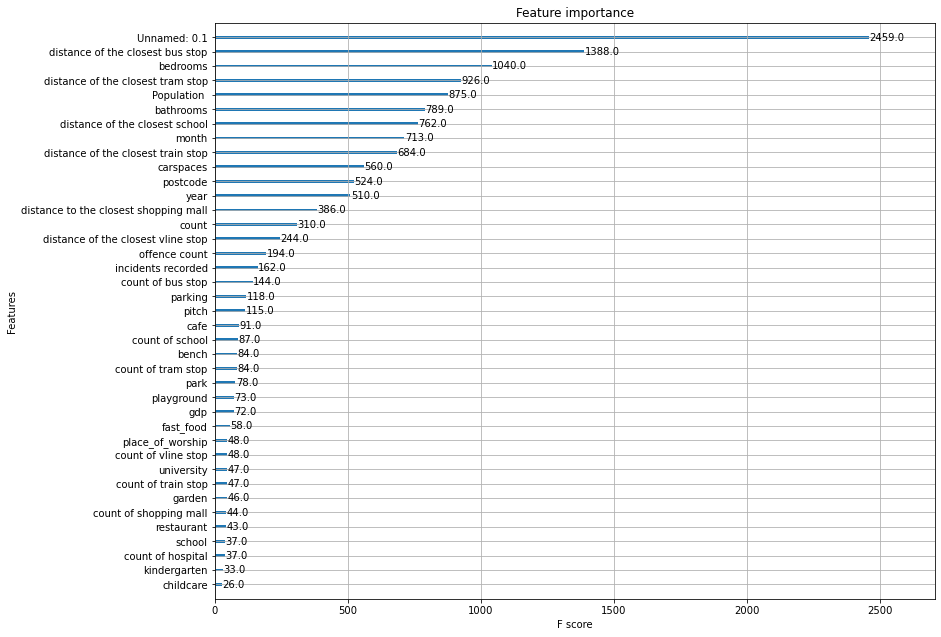

In [27]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
xgb.plot_importance(xgbc, ax)

In [228]:
df3 = pd.DataFrame()
for year in range(2023,2026):
    for month in range(1,13):
        tmp_df = df2.copy()
        year_list = [year]*len(df2)
        month_list = [month]*len(df2)
        tmp_df['year'] = year_list
        tmp_df['month'] = month_list
        df3= pd.concat([df3,tmp_df])
df3 = df3.reset_index().drop('index',axis = 1)
df3 = df3.drop('rent', axis = 1)

In [230]:
population = pd.read_csv('../data/population_forcasting.csv')
population_count = dict()
population['Postcode'] = population['Postcode'].fillna(value=0)
for index, value in population.iterrows():
    postcode = int(value['Postcode'])
    year = value['year']
    key = str(postcode)+ ' ' + str(year)
    population_count[key] = value['Total']

In [231]:
population_list = []
for index, value in df3.iterrows():
    postcode = int(value['postcode'])
    year = int(value['year'])
    key = str(postcode)+ ' ' + str(year)
    try: 
        count = population_count[key]
        population_list.append(count)
    except:
        population_list.append(None)
df3['population'] = population_list

In [232]:
def to_int(num):
    return int(num)
df3['postcode'] = df3['postcode'].apply(to_int)

In [146]:
cpi_df = pd.read_csv('../data/cpi.csv')
df3 = df3.merge(cpi_df, on = 'year', how='left')

In [234]:
f = open("../data/year_school_address.txt")
data = json.load(f)
new_school = pd.DataFrame(data, columns=['year','link','address'])
def get_postcode(add):
    add_list = add.split(' ')
    return add_list[-1]
new_school['postcode'] = new_school['address'].apply(get_postcode)

In [235]:
school_dict = {}
for index, value in new_school.iterrows():
    year = value['year']
    postcode = value['postcode']
    key = year + ' ' + postcode
    if key not in school_dict.keys():
        school_dict[key] = 1
    else:
        school_dict[key] += 1

In [236]:
for index, values in df3.iterrows():
    year = str(values['year'])
    postcode = str(values['postcode'])
    key = year + ' ' + postcode
    if key in school_dict.keys():
        school_values = values['school']
        df3.loc[index,'school'] = school_values + school_dict[key]


In [238]:
df3 = df3.merge(gdp_df, on = 'year', how='left')
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,park,playground,pitch,offence count,incidents recorded,median_rent,year,month,population,gdp
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,NaN,0.0,0.433269,...,1.0,0.0,0.0,25125.0,18185.0,850.0,2023,1,NaN,69717.12
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,NaN,...,67.0,26.0,40.0,10604.0,8777.0,800.0,2023,1,29726.0,69717.12
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,NaN,0.0,0.452666,...,19.0,8.0,24.0,20238.0,15867.0,430.0,2023,1,NaN,69717.12
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,NaN,...,20.0,14.0,42.0,9248.0,7527.0,850.0,2023,1,8946.0,69717.12
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,NaN,...,5.0,4.0,12.0,22113.0,16777.0,850.0,2023,1,9676.0,69717.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247207,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,NaN,...,119.0,48.0,190.0,55237.0,41689.0,540.0,2025,12,25571.0,74353.74
247208,4.0,5.0,4.0,3133,NaN,0.642555,64.0,NaN,0.0,0.645158,...,4.0,0.0,2.0,7751.0,5998.0,900.0,2025,12,15127.0,74353.74
247209,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,NaN,0.0,NaN,...,48.0,30.0,56.0,4762.0,3843.0,650.0,2025,12,17873.0,74353.74
247210,4.0,5.0,4.0,3844,NaN,1.741227,124.0,NaN,0.0,NaN,...,4.0,3.0,3.0,42754.0,29717.0,570.0,2025,12,8396.0,74353.74


In [240]:
df3 = df3.merge(house_count,  on = 'postcode', how = 'left')
df3 = df3.fillna(0)
df3

,bathrooms,bedrooms,carspaces,postcode,bond,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,playground,pitch,offence count,incidents recorded,median_rent,year,month,population,gdp,count
0,0.0,1.0,0.0,3008,5100.0,0.456268,5.0,0.000000,0.0,0.433269,...,0.0,0.0,25125.0,18185.0,850.0,2023,1,0.0,69717.12,4253
1,0.0,1.0,0.0,3015,1084.0,0.370457,60.0,0.405244,2.0,0.000000,...,26.0,40.0,10604.0,8777.0,800.0,2023,1,29726.0,69717.12,295
2,0.0,1.0,0.0,3053,0.0,0.449442,39.0,0.000000,0.0,0.452666,...,8.0,24.0,20238.0,15867.0,430.0,2023,1,0.0,69717.12,1280
3,0.0,1.0,0.0,3079,1304.0,0.516233,48.0,0.526467,2.0,0.000000,...,14.0,42.0,9248.0,7527.0,850.0,2023,1,8946.0,69717.12,269
4,0.0,1.0,0.0,3171,5000.0,0.642444,64.0,0.670534,2.0,0.000000,...,4.0,12.0,22113.0,16777.0,850.0,2023,1,9676.0,69717.12,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247207,4.0,5.0,4.0,3064,2340.0,0.386602,209.0,0.457571,2.0,0.000000,...,48.0,190.0,55237.0,41689.0,540.0,2025,12,25571.0,74353.74,1482
247208,4.0,5.0,4.0,3133,0.0,0.642555,64.0,0.000000,0.0,0.645158,...,0.0,2.0,7751.0,5998.0,900.0,2025,12,15127.0,74353.74,232
247209,4.0,5.0,4.0,3335,2824.0,0.129284,10.0,0.000000,0.0,0.000000,...,30.0,56.0,4762.0,3843.0,650.0,2025,12,17873.0,74353.74,237
247210,4.0,5.0,4.0,3844,0.0,1.741227,124.0,0.000000,0.0,0.000000,...,3.0,3.0,42754.0,29717.0,570.0,2025,12,8396.0,74353.74,214


In [245]:
predict_std = sc.transform(df3)
rent_list = rfc.predict(predict_std)
df3['predicted_rent'] = rent_list

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- median_rent
- population
Feature names seen at fit time, yet now missing:
- Population 
- cpi

  warnings.warn(message, FutureWarning)


In [247]:
df3.to_csv('../data/curated/predicted_df.csv')
df3 = pd.read_csv('../data/curated/predicted_df.csv')

In [249]:
suburb_postcode_df = pd.read_csv('../data/cleaned_complete.csv')[['postcode','surburb']].drop_duplicates()
suburb_postcode_df

,postcode,surburb
0,3205,south melbourne
47,3206,albert park
148,3207,port melbourne
246,3004,melbourne
868,3006,southbank
...,...,...
100625,3260,camperdown
100627,3700,tallangatta
100628,3701,eskdale
100629,3701,dartmouth


In [250]:
postcode_suburb_list = dict()
for index, value in suburb_postcode_df.iterrows():
    postcode = value['postcode']
    suburb = value['surburb']
    key = str(postcode)
    postcode_suburb_list[key] = suburb

In [252]:
p_list = []
for index, data in df3.iterrows():
    postcode = str(int(data['postcode']))
    p_list.append(postcode_suburb_list[postcode])
df3['suburb'] = p_list

In [253]:
df3.to_csv('../data/curated/predicted_df_combined.csv')

In [256]:
df3_combinded = pd.read_csv('../data/curated/predicted_df_combined.csv').drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)

In [258]:
suburb_mean_rent = pd.DataFrame(df3_combinded.groupby(['year','postcode']).mean('predicted_rent')['predicted_rent']).reset_index().rename({'predicted_rent':'rent'}, axis = 1)
suburb_mean_rent

,year,postcode,rent
0,2023,3000,651.428975
1,2023,3002,500.901923
2,2023,3003,688.538175
3,2023,3004,427.205478
4,2023,3006,661.162862
...,...,...,...
1393,2025,3977,633.570275
1394,2025,3978,662.150154
1395,2025,3980,640.940763
1396,2025,3981,625.029221


In [260]:
house_file = pd.read_csv('../data/cleaned_complete.csv').drop(['Unnamed: 0','index','dateUpdated','dateListed','geoLocation','geometry', 'index_right', 'SA2_maincode_2021','Population Increase','Earners (persons)','Median age of earners (years)','Male','Female',	'Person','Male Ratio','Female Ratio','Sum ($)','Mean ($)','Median ($)','propertyTypes','price'],axis = 1)
history_rent = pd.DataFrame(house_file.groupby(['year','postcode']).mean('rent')['rent']).reset_index().rename({'surburb':'suburb'}, axis = 1)
history_rent

,year,postcode,rent
0,2019,3000,563.484793
1,2019,3002,636.024390
2,2019,3003,525.928571
3,2019,3004,600.873817
4,2019,3006,712.826054
...,...,...,...
1499,2022,3975,522.968750
1500,2022,3976,425.000000
1501,2022,3977,456.158798
1502,2022,3978,493.750000


In [264]:
combined_rent = pd.concat([history_rent, suburb_mean_rent])
combined_rent = combined_rent.sort_values(by = ['postcode','year'])
yearly_growth_list = []
for name, group in combined_rent.groupby('postcode'):   
    group['lag(rent,1)'] = group['rent'].shift(1)
    growth_dict = dict()
    growth_dict['postcode'] = name
    for index, value in group.iterrows():
        rent = value['rent']
        lag = value['lag(rent,1)']
        rate = 0
        if pd.isna(lag):
            rete = None
        else:
            rate = (rent-lag)/lag *100
        growth_dict['year'+ ' ' + str(int(value['year']))] = rate
    yearly_growth_list.append(growth_dict)


In [272]:
rate_df = pd.DataFrame(yearly_growth_list)
top_10 = rate_df.sort_values(by = ['year 2022','year 2023','year 2024', 'year 2025'],ascending=False)[:10]

In [273]:
top_10.merge(suburb_postcode_df, on = 'postcode', how = 'left')

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025,surburb
0,3269,0.0,NaN,-30.555556,120.000000,-13.855719,0.0,0.0,port campbell
1,3726,NaN,0.000000,NaN,106.349206,-11.331078,0.0,0.0,devenish
2,3726,NaN,0.000000,NaN,106.349206,-11.331078,0.0,0.0,thoona
3,3670,0.0,NaN,NaN,88.461538,-30.698980,0.0,0.0,baddaginnie
4,3928,0.0,25.832717,-36.470588,75.925926,-44.139649,0.0,0.0,main ridge
5,3929,0.0,10.511034,-30.404624,68.992248,-24.629052,0.0,0.0,flinders
6,3816,0.0,9.219858,0.000000,67.099567,-2.466451,0.0,0.0,longwarry
7,3816,0.0,9.219858,0.000000,67.099567,-2.466451,0.0,0.0,labertouche
8,3302,0.0,NaN,11.627907,66.666667,-27.190972,0.0,0.0,branxholme
9,3230,0.0,2.313677,-5.703422,65.725806,-18.285621,0.0,0.0,anglesea


In [27]:
import pandas as pd
file = pd.read_csv('../data/curated/join.csv')
file = file.fillna(0).drop('Unnamed: 0', axis = 1)
file

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,sum_2021,sum_2022,median_2019,median_2020,median_2021,median_2022,mean_2019,mean_2020,mean_2021,mean_2022
0,1.0,1.0,0.0,0.0,3205,south melbourne,2019,1,0.0,360.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
1,2.0,2.0,1.0,0.0,3205,south melbourne,2019,1,0.0,725.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
2,1.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,500.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
3,1.0,3.0,0.0,0.0,3205,south melbourne,2019,1,0.0,795.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
4,2.0,2.0,0.0,0.0,3205,south melbourne,2019,1,0.0,825.0,...,9.900238e+08,1.036672e+09,66259.675774,67037.994227,68466.042203,69810.297518,95462.489940,95992.606079,97119.154757,97731.370326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,1.0,3.0,1.0,0.0,3701,dartmouth,2022,5,0.0,280.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100635,1.0,3.0,1.0,0.0,3701,dartmouth,2022,6,0.0,290.0,...,2.240127e+08,2.293470e+08,41070.537894,42207.801316,43272.563277,44583.025987,44794.347421,45114.652912,45129.772942,45276.629966
100636,1.0,3.0,2.0,0.0,3700,tallangatta,2022,8,0.0,470.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100637,1.0,3.0,2.0,0.0,3700,tallangatta,2021,3,0.0,310.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
value_list = []
for index, values in file.iterrows():
    year = values['year']
    column_list = list(values.index)[:44]
    for i in list(values.index)[44:]:
        if str(year) in i:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
    
    # print(list(values))

In [31]:
file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [34]:
file = file[file['SA2 NAME'] != 0]

住房成本：rent/income 0.2
出行成本：count * 最近距离平均数 0.2
就餐便利性： 'cafe'，‘fast_food'，restaurant' 0.1
环境：  'garden','park', 'playground', 'pitch'，'bench' 0.1
教育：'childcare','kindergarten','school', 'university' 0.1
安全： 'offence count', 'incidents recorded' 0.1
医疗：'count of hospital' 0.1
购物： shopping mall 0.1

In [39]:
index = []
for name, group in file.groupby('surburb'):
    rent = group['rent'].median()
    median_income = group['median'].fillna(0).median()
    house_cost = rent/(median_income + 0.00001)
    bus = int(list(group['count of bus stop'].drop_duplicates())[0]) * group['distance of the closest bus stop'].mean()
    tram = int(list(group['count of tram stop'].drop_duplicates())[0]) * group['distance of the closest tram stop'].mean()
    train = int(list(group['count of train stop'].drop_duplicates())[0]) * group['distance of the closest train stop'].mean()
    vline = int(list(group['count of vline stop'].drop_duplicates())[0]) * group['distance of the closest vline stop'].mean()
    shopping_mall = int(list(group['count of shopping mall'].drop_duplicates())[0]) * group['distance to the closest shopping mall'].mean()
    eating = list(group['cafe'].drop_duplicates())[0] + list(group['fast_food'].drop_duplicates())[0] + list(group['restaurant'].drop_duplicates())[0]
    enviornment = list(group['garden'].drop_duplicates())[0] + list(group['park'].drop_duplicates())[0] + list(group['playground'].drop_duplicates())[0]+list(group['pitch'].drop_duplicates())[0]+list(group['place_of_worship'].drop_duplicates())[0]
    education = list(group['count of school'].drop_duplicates())[0] + list(group['childcare'].drop_duplicates())[0] + list(group['kindergarten'].drop_duplicates())[0]+list(group['university'].drop_duplicates())[0]
    safty = list(group['offence count'].drop_duplicates())[0] + list(group['incidents recorded'].drop_duplicates())[0]
    health_care = list(group['count of hospital'].drop_duplicates())[0]
    livable_index = house_cost * 0.2 + (bus+tram+train+vline) * 0.2 + shopping_mall*0.1 + eating*0.1 + education*0.1+enviornment*0.1 +health_care*0.1 + safty*0.1
    index.append([name,livable_index])
index_df = pd.DataFrame(index, columns=['suburb','index'])


In [40]:
index_df.sort_values(by = 'index', ascending=False)

,suburb,index
522,west melbourne,8.201820e+06
142,dandenong north,1.793347e+04
143,dandenong south,1.793308e+04
141,dandenong,1.793308e+04
208,frankston,1.429888e+04
...,...,...
145,dartmouth,5.380735e+01
186,eskdale,5.379380e+01
401,penshurst,5.060438e+01
213,gerrigerrup,5.050359e+01
